In [12]:
#  !pip install pandas transformers torch datasets numpy openpyxl scikit-learn
#  !pip install accelerate -U

In [13]:
import pandas as pd
import transformers, torch

"""
Remove uneecessay new lines
remove duplicates within one cell
Remove links?
use keywords to make sure that correct classification is done
make validation set more class balanced, i.e. equal num of examples for each category
"""
# load data and rename TextEntry column
df = pd.read_excel("../../../carlos_data/preprocessed_data_v2.xlsx")
df = df.rename(columns={"TextEntry":"Description"})

# convert data to dictionary
data = df.to_dict("records")

# Split the data into train and validation and test sets
from sklearn.model_selection import train_test_split 
train_dict, test_dict = train_test_split(data, test_size=0.20, random_state=42)
test_dict, validation_dict = train_test_split(test_dict, test_size=0.50, random_state=42)

# Create Dataset objects
from datasets import Dataset
train_dataset = Dataset.from_list(train_dict)
test_dataset = Dataset.from_list(test_dict)
validation_dataset = Dataset.from_list(validation_dict)

# Create DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({
	"train": train_dataset,
	"test": test_dataset,
	"validation": validation_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['ObjectID', 'Description', 'Subjective', 'Gender', 'Jargon', 'Social'],
        num_rows: 161
    })
})


Text(0.5, 1.0, 'Texts length distribution (number of words)')

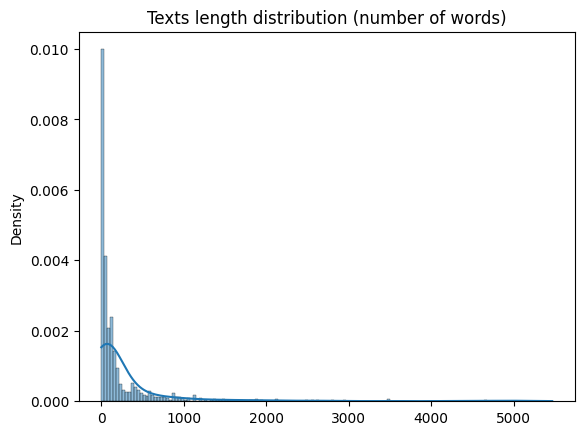

In [14]:
import seaborn as sns

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Description"], df["Social"], test_size=0.2, random_state=42
)

text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)")

In [15]:
# credit: https://github.com/NielsRogge/Transformers-Tutorials
labels = [label for label in dataset["train"].features.keys() if label not in ["ObjectID", "Description"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Subjective', 'Gender', 'Jargon', 'Social']

In [16]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# credit: https://github.com/NielsRogge/Transformers-Tutorials
def preprocess_data(data):

	# save the given batch of descs
	descs = data["Description"]

	# encode them using bert tokenizer
	encoding = tokenizer(descs, padding=True, truncation=True, max_length=512)#.to("mps")

	# create numpy array (no need to convert T/F to 0/1 since we annotated that way)
	# MATRIX FORMAT:
	# |---------------------------------
	# | bias   | bias1 bias2 bias3 bias4
	# |--------+------------------------
	# | desc0  |   1     0     1     0
	# | desc1  |   0     1     0     1
	# | desc2  |   0     1     0     0
	# | ...    |  ...   ...   ...   ...
	# 
	# Convert integers to float and data to an NDarray
	subjective = np.array(data["Subjective"], dtype=float)
	gender = np.array(data["Gender"], dtype=float)
	jargon = np.array(data["Jargon"], dtype=float)
	social = np.array(data["Social"], dtype=float)
	# Stack the arrays column-wise to form a 2D array (matrix)
	labels_matrix = np.stack((subjective, gender, jargon, social), axis=1)

	
	# # Credit ChatGPT
	# # Validate the data stacking by comparing 3 random indices
	# import random
	# for _ in range(3):
	# 	idx = random.randint(0, len(subjective) - 1)
	# 	dataset_labels = [data["Subjective"][idx], data["Gender"][idx], data["Jargon"][idx], data["Social"][idx]]
	# 	matrix_labels = labels_matrix[idx].tolist()
	# 	assert dataset_labels == matrix_labels, f"Mismatch at index {idx}: {dataset_labels} != {matrix_labels}"
	# 	print(f"Index {idx} matches: {dataset_labels}")


	# FORMAT OF var encoding of type BatchEncoding (the length of the vals of each key 
	# equal the num of descs/objects in given batch):
	# input_ids: [101, 1030, 4748, 7229, 1035, ...], ...
	# token_type_ids: [0, 0, 0, 0, 0, ...], ...
	# attention_mask: [1, 1, 1, 1, 1, ...], ...
	# labels: [1.0, 1.0, 0.0, 0.0], ...
	encoding["labels"] = labels_matrix.tolist()

	return encoding

In [17]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map: 100%|██████████| 161/161 [00:00<00:00, 272.22 examples/s]


In [18]:
# see example
print(tokenizer.decode(encoded_dataset["train"][0]["input_ids"]))
print(encoded_dataset["train"][0]["labels"])

[CLS] pendant in the form of a bird? no provenance information in files. date range comes from memo in accession lot that says witten collection was built between 1960 and 1985. location verified, inventory 2001 location verified, inventory 2003. location verified, inventory 9, fall 2004. october 1992 descriptor moved. describes buildings having engaged columns or pilasters along the sides and rear and freestanding columns along the front. doesn't look real. not worth looking at under magnification! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [19]:
# make dataset a standard torch dataset by converting to tensors (and more?)
encoded_dataset.set_format("torch")

In [20]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)#.to("mps")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
"""
Add Warmup?
Experiment with learning rate
experiment with batch size
experient with gradient_accumulation_steps
another metric?
Choose another optimizer: RMSprop, SGD...
Increase the learning rate by default and then use the callback ReduceLROnPlateau
"""
# use keras instead of huggung face to make it easier to work with messing with layers
# remove entries greater than 512 words to remove noise
# enchance data by repeatung key terms
# cut 512 from middle of the dataset
# try giving it only the labels with 5 word context
# try doing subtext technique to give it 1000 words


from transformers import TrainingArguments, Trainer

num_epochs = 100
batch_size = 8
lr = 2e-5
metric_name = "f1"
decay = 0.01

model_path = "/mnt/d/Skull/coding/model/"
tokenizer_path = "./tokenizer"
logs_path = "./logs"

with open('../../../hg_token.txt', 'r') as file:
	hg_token = file.read()


# args for training the model
# save the model every epoch and choose the best performing epoch as the final version of the model
args = TrainingArguments(
	eval_strategy = "epoch",
	save_strategy = "epoch",
    # save_total_limit = 5,
	logging_strategy = "epoch",
	learning_rate = lr,
	per_device_train_batch_size = batch_size,
	per_device_eval_batch_size = batch_size,
	num_train_epochs = num_epochs,
	weight_decay = decay,
	load_best_model_at_end = True,
	metric_for_best_model = metric_name,
	logging_dir = logs_path,
	output_dir = model_path,
    warmup_steps=100,
	# use_mps_device = True,
	use_cpu = False,
	logging_steps = 1,
	# gradient_accumulation_steps=2,
	hub_token = hg_token,
	hub_model_id = "raasikhk/carlos_bert_v2",
	push_to_hub=True,
)

import os
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix
from transformers import EvalPrediction
import torch
from numpy import ndarray
import glob
import matplotlib.pyplot as plt
from typing import Tuple

def get_next_image_number(directory: str) -> int:
    if not os.path.exists(directory):
        os.makedirs(directory)
        return 1
    images = glob.glob(os.path.join(directory, '*.png'))
    if not images:
        return 1
    numbers = [int(os.path.basename(image).split('_')[0]) for image in images]
    return max(numbers) + 1

def plot_confusion_matrix(cm, save_path, title):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, rotation=45)
    plt.yticks(tick_marks, tick_marks)
    
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def my_accuracy_score(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[int, int, int, int]:
    directory = 'cm'
    image_number = get_next_image_number(directory)
    
    labels = ["Subjective", "Gender", "Jargon", "Social"]
    true_pos_list, false_pos_list, true_neg_list, false_neg_list = [], [], [], []

    for i, label in enumerate(labels):
        save_path = os.path.join(directory, f'{image_number}_{label}.png')
        
        # Calculate confusion matrix for the current label
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        # Plot confusion matrix
        plot_confusion_matrix(cm, save_path, f'Confusion Matrix - {label}')
        
        # Calculate true positives, false positives, true negatives, false negatives
        true_pos = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 1))
        false_pos = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 1))
        true_neg = np.sum((y_true[:, i] == 0) & (y_pred[:, i] == 0))
        false_neg = np.sum((y_true[:, i] == 1) & (y_pred[:, i] == 0))
        
        true_pos_list.append(true_pos)
        false_pos_list.append(false_pos)
        true_neg_list.append(true_neg)
        false_neg_list.append(false_neg)
    
    return (
        sum(true_pos_list), sum(false_pos_list), 
        sum(true_neg_list), sum(false_neg_list)
    )


def partial_accuracy_score(y_true: ndarray, y_pred: ndarray):
	num_objects = len(y_true)
	num_labels = len(y_true)*4
	correct_predictions = 0
	
	for i in range(num_objects):
		for j in range(len(y_true[i])):
			if y_true[i][j] == y_pred[i][j]:
				correct_predictions += 1
	
	accuracy = correct_predictions / num_labels
	return accuracy

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
	# first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
	sigmoid = torch.nn.Sigmoid()
	probs = sigmoid(torch.Tensor(predictions))
	# next, use threshold to turn them into integer predictions
	y_pred = np.zeros(probs.shape)
	y_pred[np.where(probs >= threshold)] = 1
	# finally, compute metrics
	y_true = labels
	f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
	roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
	accuracy = accuracy_score(y_true, y_pred)
	myacc = partial_accuracy_score(y_true, y_pred)
	true_pos, false_pos, true_neg, false_neg = my_accuracy_score(y_true, y_pred)
	# return as dictionary
	metrics = {'f1': f1_micro_average,
				'roc_auc': roc_auc,
				'exact_match_acc': accuracy,
				"partial_acc": myacc,
				'true_pos': true_pos,
        		'true_neg': true_neg,
        		'false_neg': false_neg,
				'false_pos': false_pos}
	return metrics

def compute_metrics(p: EvalPrediction):
	preds = p.predictions[0] if isinstance(p.predictions, 
			tuple) else p.predictions
	result = multi_label_metrics(
		predictions=preds, 
		labels=p.label_ids)
	return result



In [22]:
trainer = Trainer(
	model,
	args,
	train_dataset=encoded_dataset["train"],
	eval_dataset=encoded_dataset["validation"],
	tokenizer=tokenizer,
	compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Exact Match Acc,Partial Acc,True Pos,True Neg,False Neg,False Pos
1,0.428400,0.301900,0.577540,0.737861,0.571429,0.877329,54,511,47,32
2,0.300000,0.283439,0.545455,0.705277,0.596273,0.883540,45,524,56,19
3,0.262400,0.294516,0.602041,0.758930,0.577640,0.878882,59,507,42,36
4,0.209000,0.320963,0.528090,0.705049,0.559006,0.869565,47,513,54,30
5,0.176000,0.346100,0.547264,0.730841,0.515528,0.858696,55,498,46,45
6,0.153400,0.371906,0.554348,0.723009,0.565217,0.872671,51,511,50,32
7,0.120500,0.389813,0.564103,0.736366,0.571429,0.868012,55,504,46,39
8,0.101000,0.425688,0.582915,0.750296,0.565217,0.871118,58,503,43,40
9,0.076100,0.438775,0.579186,0.765266,0.527950,0.855590,64,487,37,56
10,0.067000,0.442058,0.581281,0.752484,0.559006,0.868012,59,500,42,43


TrainOutput(global_step=16000, training_loss=0.028679579094052315, metrics={'train_runtime': 9773.3715, 'train_samples_per_second': 13.097, 'train_steps_per_second': 1.637, 'total_flos': 3.3678819852288e+16, 'train_loss': 0.028679579094052315, 'epoch': 100.0})

TrainOutput(global_step=1200, training_loss=0.05973712073231582, metrics={'train_runtime': 1398.0176, 'train_samples_per_second': 13.734, 'train_steps_per_second': 0.858, 'total_flos': 5051822977843200.0, 'train_loss': 0.05973712073231582, 'epoch': 15.0})


In [24]:
trainer.evaluate()

{'eval_loss': 0.5802189707756042,
 'eval_f1': 0.6341463414634146,
 'eval_roc_auc': 0.7858705760078771,
 'eval_exact_match_acc': 0.5900621118012422,
 'eval_partial_acc': 0.8835403726708074,
 'eval_true_pos': 65,
 'eval_true_neg': 504,
 'eval_false_neg': 36,
 'eval_false_pos': 39,
 'eval_runtime': 3.6007,
 'eval_samples_per_second': 44.714,
 'eval_steps_per_second': 5.832,
 'epoch': 100.0}

{'eval_loss': 0.324933260679245,
 'eval_f1': 0.7070707070707071,
 'eval_roc_auc': 0.8216727750123078,
 'eval_accuracy': 0.7018633540372671,
 'eval_runtime': 3.7853,
 'eval_samples_per_second': 42.533,
 'eval_steps_per_second': 2.906,
 'epoch': 15.0}

In [23]:
# view logs (only needed for analysis)
# !pip install tensorboard
!tensorboard --logdir logs

  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
  Using cached werkzeug-3.0.3-py3-none-any.whl.metadata (3.7 kB)
Using cached tensorboard-2.17.0-py3-none-any.whl (5.5 MB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 27.5 MB/s eta 0:00:00a 0:00:01
Using cached Markdown-3.6-py3-none-any.whl (105 kB)
Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
Using cached werkzeug-3.0.3-py3-none-any.whl (227 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip in

In [35]:
# model.save_pretrained("model")
# tokenizer.save_pretrained("tokenizer")
# tokenizer = transformers.BertTokenizer.from_pretrained("tokenizer")
# model = transformers.BertForSequenceClassification.from_pretrained("model/checkpoint-1200")

In [28]:
# test a description
text = "December 1992 lead-in term added. January 1991 alternate term added. Object fumigated in Orkin's Piedmont vault with Vikane in 1994"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

logits = outputs.logits
logits.shape

# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
print(probs)
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

tensor([0.0007, 0.0031, 0.0750, 0.0016], grad_fn=<SigmoidBackward0>)
[]


**PREDICTION**

Run the first code block only if you have the model folder and have NOT done training above

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

In [36]:
# TEST THE MODEL
# IF YOU DONT WANT TO TRAIN LOAD MODEL FROM HUGGINGFACE


from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

device = 0 if torch.cuda.is_available() else -1

if tokenizer == None:
    tokenizer = AutoTokenizer.from_pretrained("raasikhk/carlos_bert_v1")
if model == None:
    model = AutoModelForSequenceClassification.from_pretrained("raasikhk/carlos_bert_v1")

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, truncation=True, padding=True, device=device)


texts = [
    "The artifact was created in the 19th century and is considered highly valuable.",
    "This piece shows signs of heavy wear and might not be authentic."
]

# Make predictions
predictions = pipe(texts)

# Print the predictions
for i, text in enumerate(texts):
    print(f"Text: {text}")
    print(f"Predictions: {predictions[i]}\n")


Text: The artifact was created in the 19th century and is considered highly valuable.
Predictions: [{'label': 'Subjective', 'score': 0.09203276038169861}, {'label': 'Jargon', 'score': 0.026056140661239624}, {'label': 'Social', 'score': 0.009623771533370018}, {'label': 'Gender', 'score': 0.00038654549280181527}]

Text: This piece shows signs of heavy wear and might not be authentic.
Predictions: [{'label': 'Subjective', 'score': 0.8277921676635742}, {'label': 'Jargon', 'score': 0.043133534491062164}, {'label': 'Social', 'score': 0.0035685293842107058}, {'label': 'Gender', 'score': 0.0008079292019829154}]



In [61]:
# CALCULATE ACCURACY

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# if tokenizer == None:
#     tokenizer = AutoTokenizer.from_pretrained("raasikhk/carlos_bert_v1")
# if model == None:
#     model = AutoModelForSequenceClassification.from_pretrained("raasikhk/carlos_bert_v1")

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, truncation=True, padding=True, device=device)

# Replace with your test dataset
test_descriptions = dataset["validation"]["Description"]

# Get predictions
predictions = pipe(test_descriptions)

labels= ["Subjective", "Gender", "Jargon", "Social"]

print("\nPartial correct score: ")

score = 0
total = 0
for p in predictions:

    for i in range(4):
        if p[i]["score"] >=0.5:
            prediction=1
        else:
            prediction=0
        
        if dataset["validation"][i][labels[i]] == prediction:
            score +=1
        total+=1
print(f"{score} / {total}")
print(score/total)

print("\nAll correct score: ")

score = 0
total = 0
for p in predictions:
    all_c=True
    for i in range(4):
        if p[i]["score"] >=0.5:
            prediction=1
        else:
            prediction=0
        
        if dataset["validation"][i][labels[i]] != prediction:
            all_c = False
        total+=1
        if (all_c):
            score+=1

print(f"{score} / {total}")
print(score/total)


Partial correct score: 
551 / 644
0.8555900621118012

All correct score: 
272 / 644
0.422360248447205
